In [1]:
import geostatspy.GSLIB as GSLIB 
import geostatspy.geostats as geostats 
import os                                               # to set current working directory 
import numpy as np                                      # arrays and matrix math
import pandas as pd                                     # DataFrames
import matplotlib.pyplot as plt   
import scipy.io as sio
import scipy.stats as stats
from scipy.ndimage import gaussian_filter
from scipy.signal import decimate
from numpy.matlib import repmat
from scipy.interpolate import interp2d

In [2]:
np.random.seed(155)
aziRand= np.arange(0,360,9)
gradient = -0.31
for ireal in range(40):
    nreal=1
    nx=48
    ny=45
    
    lower, upper = 250, 4000
    mu, sigma = 700, 1500
    perm_stats = stats.truncnorm(
        (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    
    #create number of nucleation points
    n=40
    data = []
    tempcoord = []
    while len(data) < 40:
        x = np.random.randint(0,nx)
        y = np.random.randint(0,ny)
        coord = (x,y)
        if (x,y) not in tempcoord:
            tempcoord.append(coord)
            p = perm_stats.rvs(size=1)[0]
            data.append([int(x),int(y),p])
    data = np.array(data)
    
    datadf = pd.DataFrame(data,columns=['X','Y','Permeability'])

    cell_size = 1
    seed = np.random.randint(99999999)
    vario = GSLIB.make_variogram(0.0,nst=1,it1=2,cc1=1.0,azi1=aziRand[ireal],hmaj1=1000,hmin1=500) # assume variogram model
    
    #simulate
    perm_sim = GSLIB.sgsim(nreal, datadf, 'X', 'Y', 'Permeability', nx, ny, cell_size, seed, vario, "simulation")             
    poro_sim = 0.063*(np.log10(perm_sim) + 1.3) + 0.02;


    #################################################
    # Work on Permeability

    #add seal - PERMEABILITY
    withSeal_Perm = np.ones((ny,nx)) *10
    yStarting = 28
    thickness = 10
    for j in range(yStarting,yStarting+thickness+1): 
        for i in range(nx): 
           new_y = round((gradient * i) +j);
           withSeal_Perm[new_y,i] = perm_sim[new_y,i]
         
    # Convert to what Matlab likes       
    withSealn_Perm = (withSeal_Perm)[:,:,None]
    perm3d = np.repeat(withSealn_Perm, 32,axis=2)
    perm3d = perm3d.swapaxes(0,2)       
    
    #################################################
    # Work on Porosity
           
    #add seal - Porosity
    withSeal_Poro = np.ones((ny,nx)) * 0.05
    yStarting = 28
    thickness = 10
    for j in range(yStarting,yStarting+thickness+1): 
        for i in range(nx): 
           new_y = round((gradient * i) +j);
           withSeal_Poro[new_y,i] = poro_sim[new_y,i]    
           
    # convert to matlab format
    withSealn_Poro = (withSeal_Poro)[:,:,None]
    poro3d = np.repeat(withSealn_Poro, 32,axis=2)
    poro3d = poro3d.swapaxes(0,2)       

    break

    # #save to py
    # np.save('data/py_perm_poro/perm{}.npy'.format(ireal),perm3d)
    # np.save('data/py_perm_poro/poro{}.npy'.format(ireal),poro3d)

    # #save to Matlab
    # sio.savemat('data/mat_perm_poro/perm{}.mat'.format(ireal),{'perm3d':perm3d})
    # sio.savemat('data/mat_perm_poro/poro{}.mat'.format(ireal),{'poro3d':poro3d})

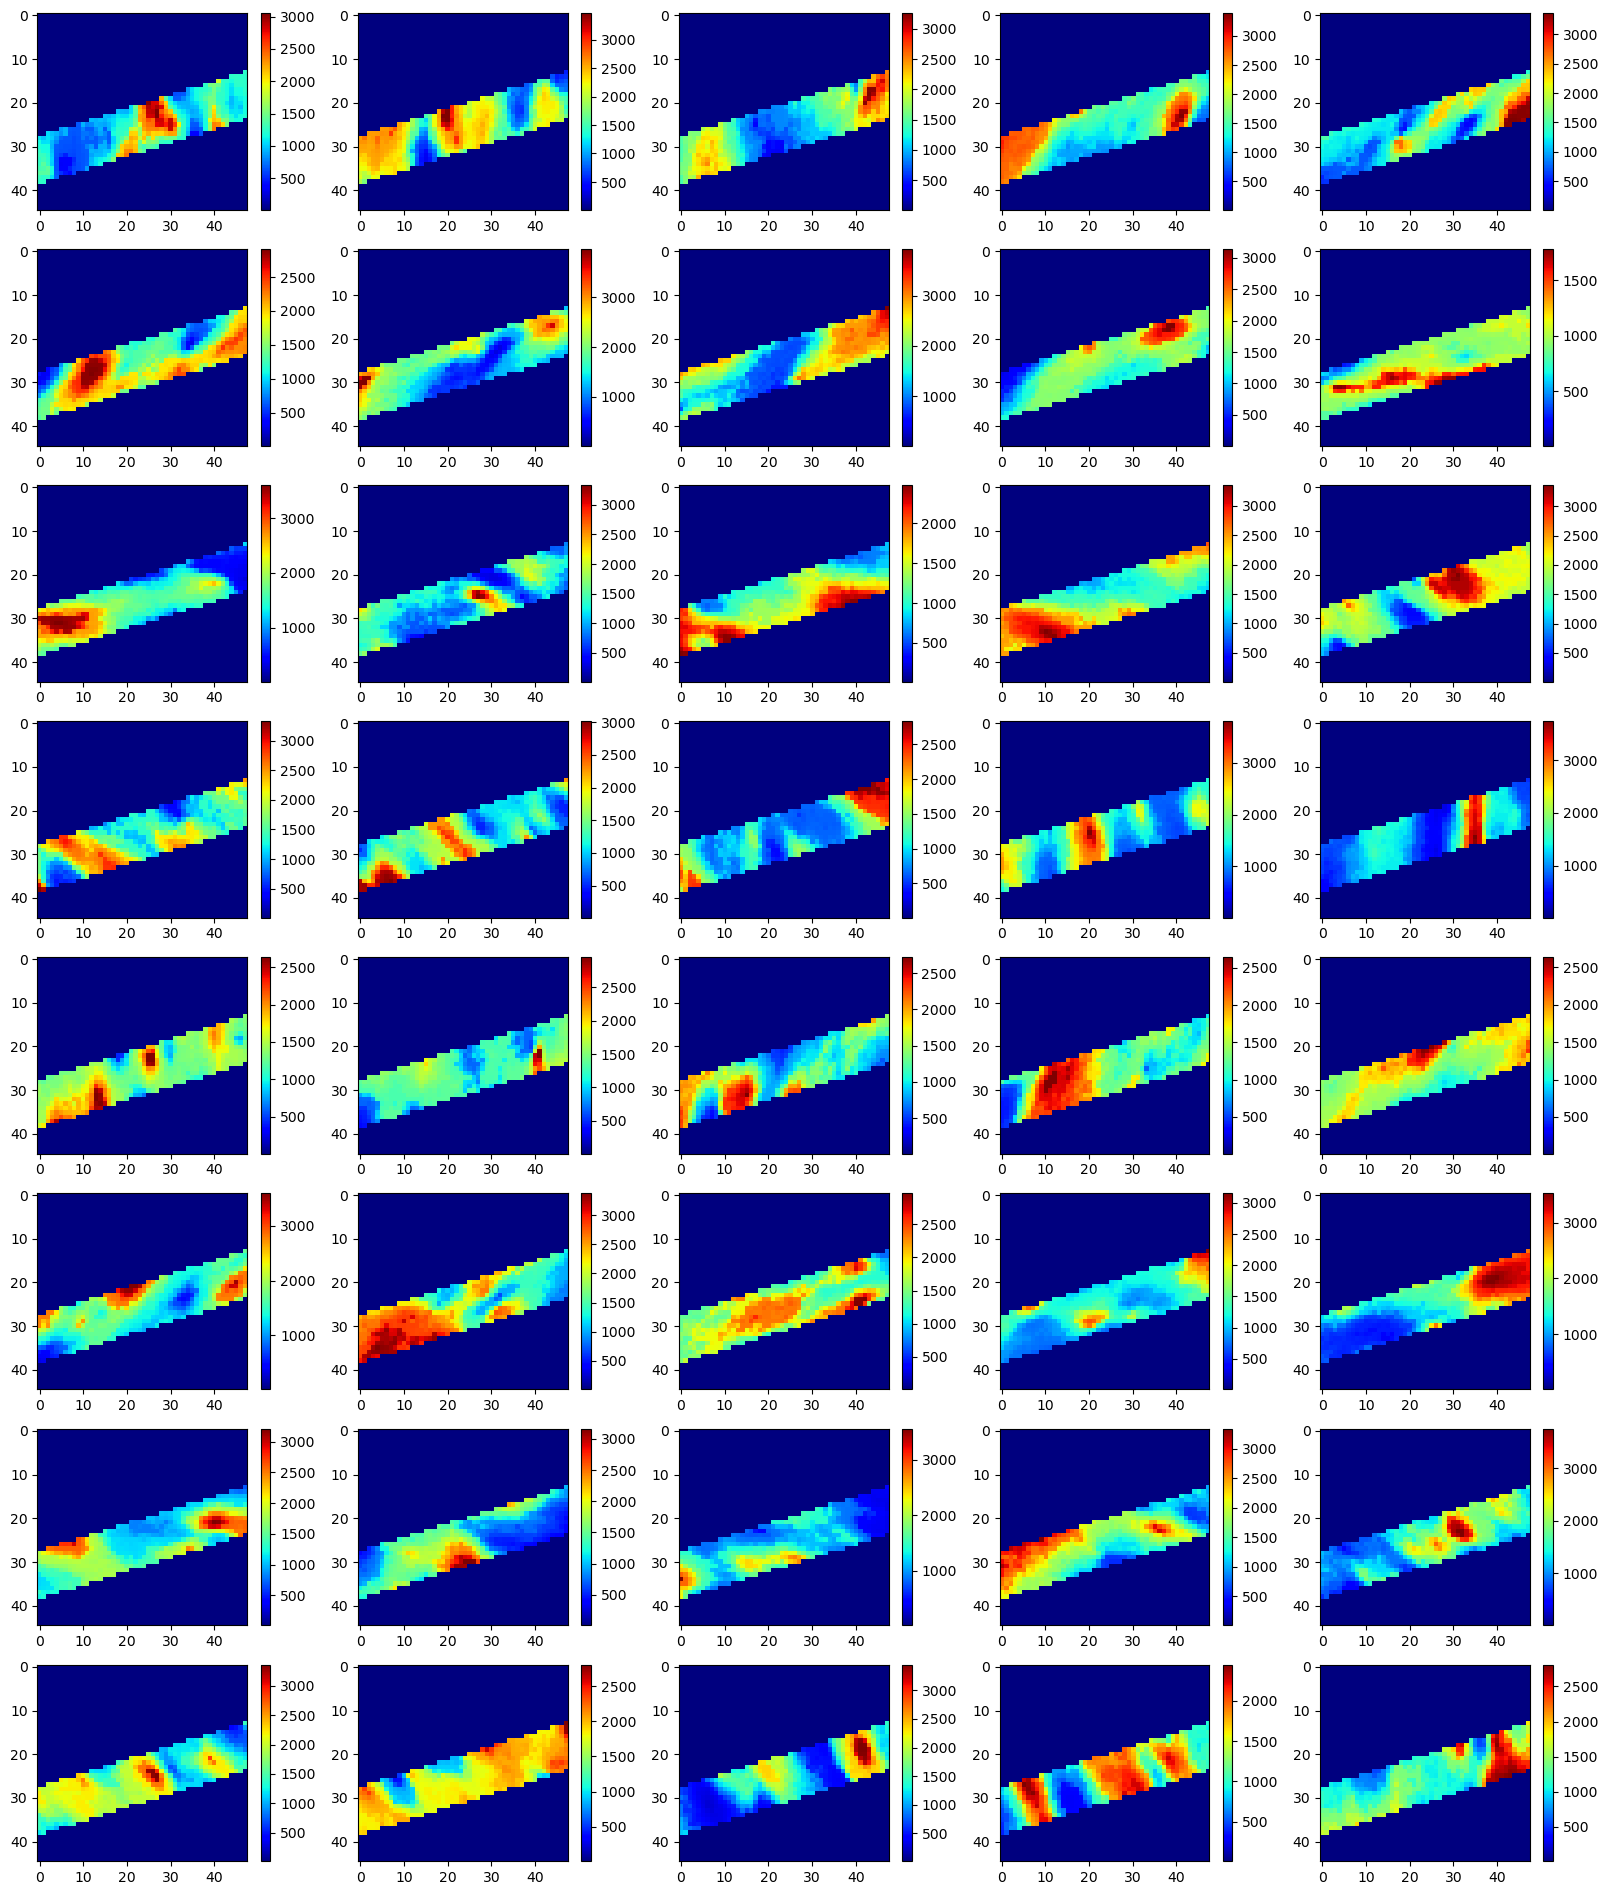

In [3]:
#Permeability
c = 0
fig, axs = plt.subplots(8,5,figsize=(20,24))
for i in range(8):
    for j in range(5):
        a = np.load('data/py_perm_poro/perm{}.npy'.format(c))
        slice2d = a[16,:,:].T
        ax = axs[i,j]
        im = ax.imshow(slice2d, cmap='jet')
        cbar = plt.colorbar(im, ax=ax,fraction=0.04)
        c = c+1

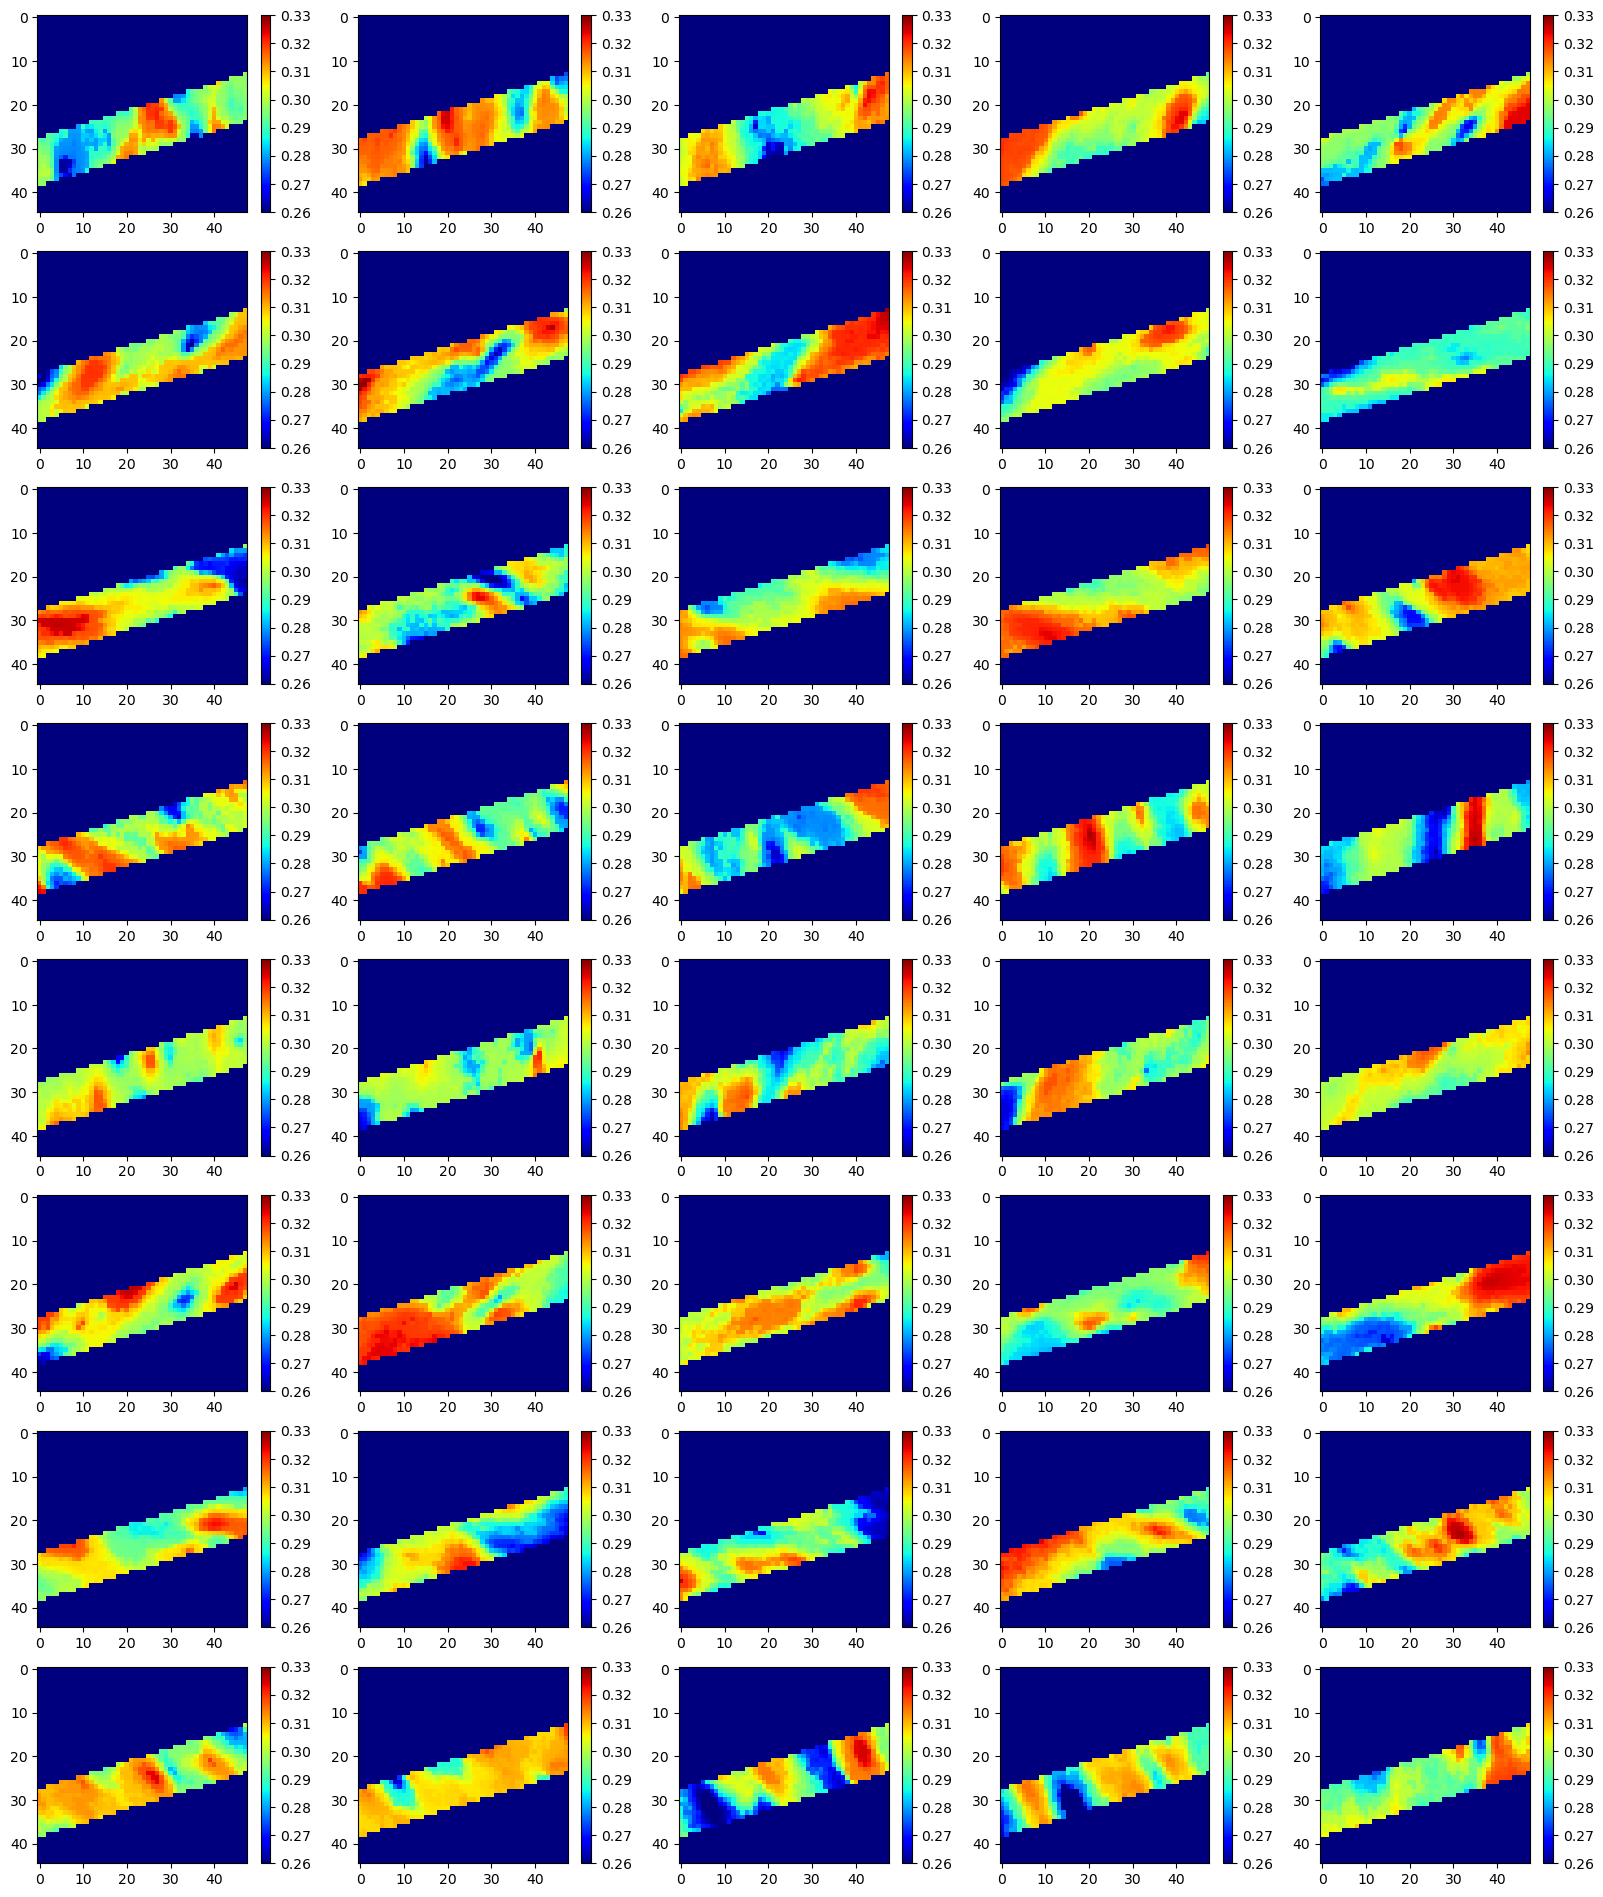

In [4]:
#Porosity
c = 0
fig, axs = plt.subplots(8,5,figsize=(20,24))
for i in range(8):
    for j in range(5):
        a = np.load('data/py_perm_poro/poro{}.npy'.format(c))
        slice2d = a[16,:,:].T
        ax = axs[i,j]
        im = ax.imshow(slice2d, cmap='jet',vmin=0.26,vmax=0.33)
        cbar = plt.colorbar(im, ax=ax,fraction=0.04)
        c = c+1